<a href="https://colab.research.google.com/github/Ibraheem101/Made-With-ML/blob/dev/notebooks/mwml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLOPs**

## **Setup**

### **Clone Github repository**

In [1]:
! git clone https://github.com/GokuMohandas/Made-With-ML.git

fatal: destination path 'Made-With-ML' already exists and is not an empty directory.


In [2]:
! pwd

/content


In [3]:
import os
print(os.getcwd())

/content


In [4]:
new_directory = "/content/Made-With-ML"
os.chdir(new_directory)

In [5]:
print(os.getcwd())

/content/Made-With-ML


In [6]:
import sys
sys.path.append('/content/Made-With-ML')

### **Install requirements**

In [7]:
! pip install --upgrade pip setuptools wheel

In [8]:
pip install -r requirements.txt

In [9]:
! pre-commit install
! pre-commit autoupdate

pre-commit installed at .git/hooks/pre-commit
Updating https://github.com/pre-commit/pre-commit-hooks ... already up to date.


Support for third party widgets will remain active for the duration of the session. To disable support:

In [10]:
from google.colab import output
output.disable_custom_widget_manager()

In [11]:
import os
import re
import json
import math
import nltk
import time
import torch
import gensim
import random
import urllib
import tempfile
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
# Support for third party widgets
from google.colab import output
output.enable_custom_widget_manager()

### **Ray Setup**

In [13]:
# Issues with 2.7
# !pip install ray==2.6.0

In [14]:
import ray

In [15]:
ray.__version__

'2.7.0'

In [16]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-11-01 10:04:29,678	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.12', ray_version='2.7.0', ray_commit='b4bba4717f5ba04ee25580fe8f88eed63ef0c5dc', protocol_version=None)

In [17]:
ray.cluster_resources()

{'memory': 7871080859.0,
 'object_store_memory': 3935540428.0,
 'CPU': 2.0,
 'node:172.28.0.12': 1.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0,
 'accelerator_type:None': 1.0}

In [18]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 1}

## **Data**

In [19]:
import pandas as pd

In [20]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

id           created_on                                              title   
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...  \
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  25  2020-03-07 23:04:31                                      AttentionWalk   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...            other  
3  A curated list of Monte Carlo tree search pape...            other  
4  A PyTorch Implementation of "Watch Your Step: ...            other

In [21]:
df.to_csv("mwml_dataset.csv", index=False)

In [22]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

### **Data Splitting**

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

What are the criteria we should focus on to ensure proper data splits?
* Randomness
* Stratification (for imbalanced datasets)
* Sufficient data size in each subset
* Temporal data handling (for time-series data)
* Consistency across models
* Reproducibility with random seed
* Adequate validation set size for hyperparameter tuning
* Complete separation of the test set from training and validation data.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [26]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [27]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [28]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [29]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

### **Exploratory Data Analysis**

In [30]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [31]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

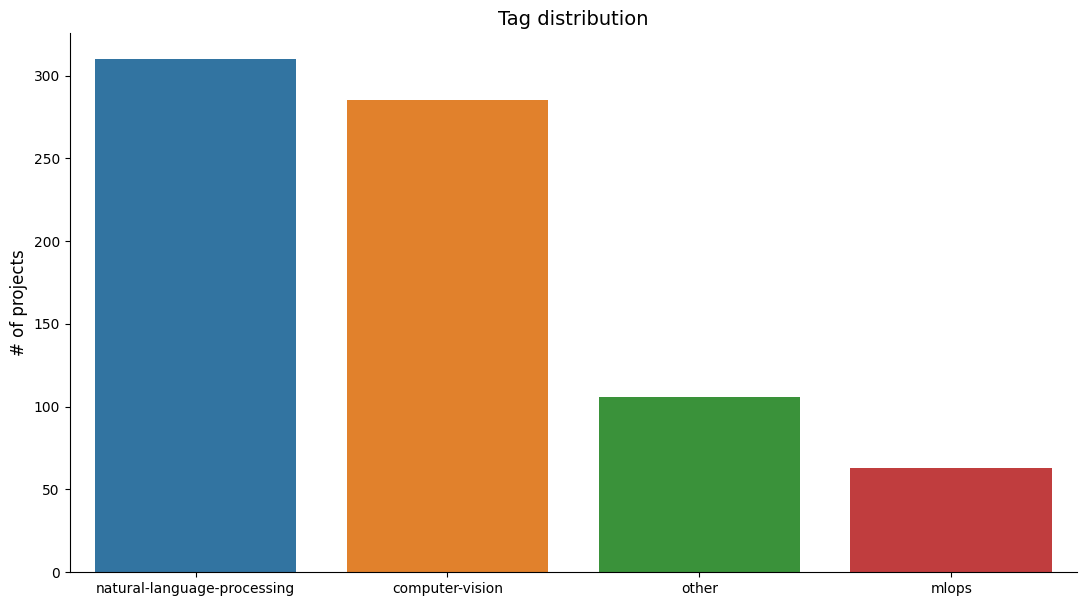

In [32]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(13, 7))
sns.barplot(x=list(tags), y=list(tag_counts))
sns.despine()
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()
# plt.xticks(rotation=45)

There's some data imbalance but we'll deal with that before modeling

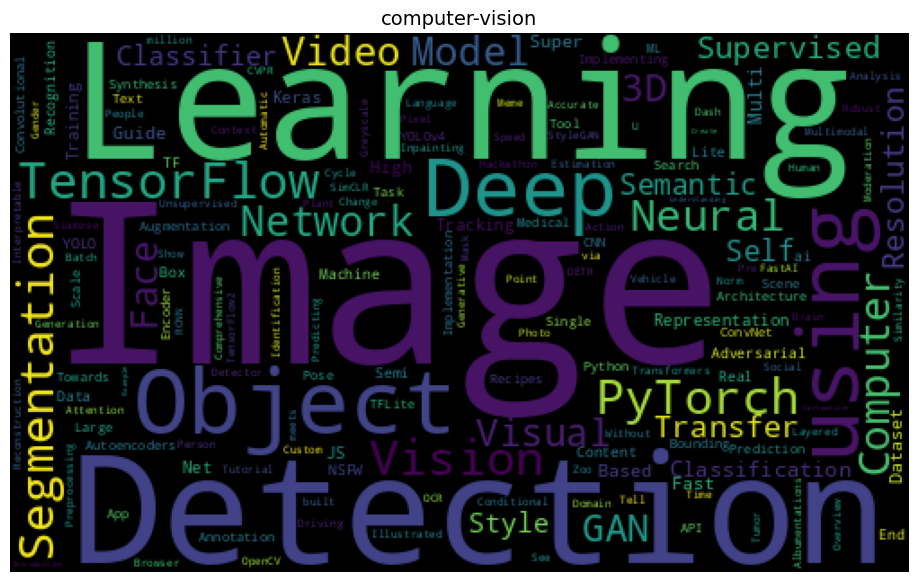

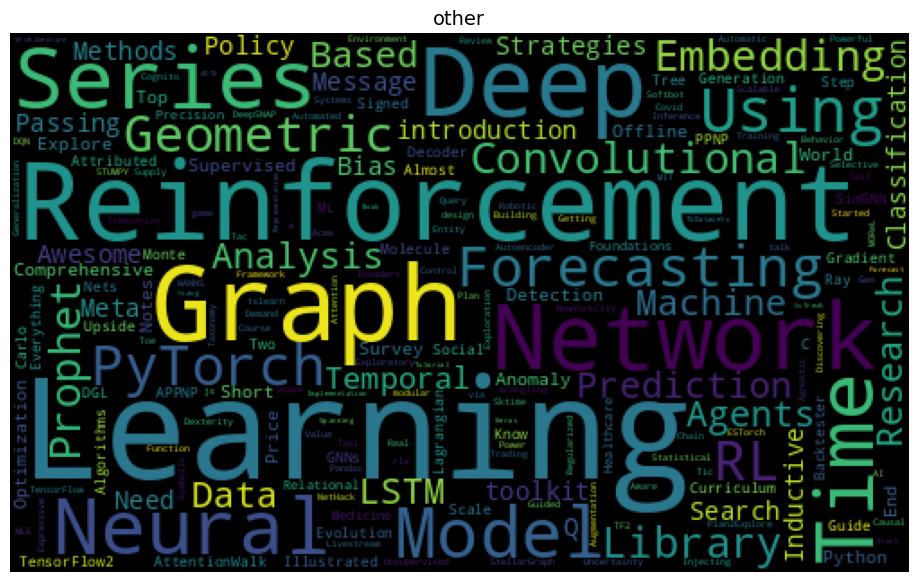

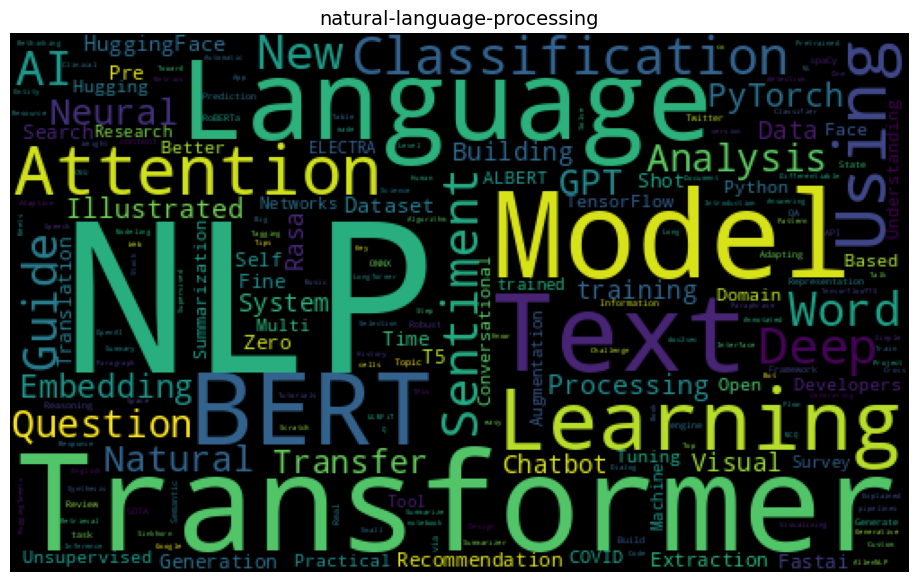

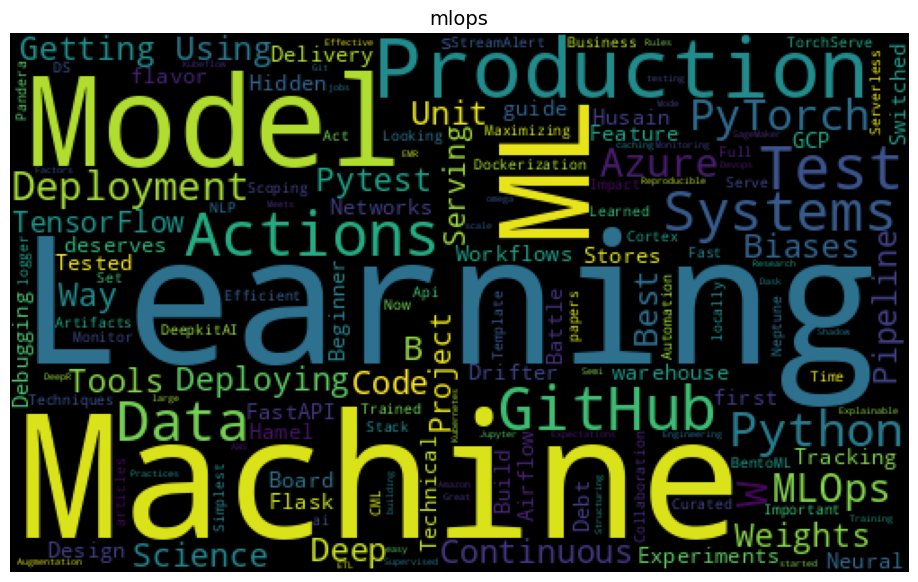

In [33]:
# Examine word distribution
# Create a list to store the generated WordCloud plots
cloud_plots = []

for tag in df['tag'].unique():
    plt.figure(figsize=(13, 7))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text)) #function requires a single string as input
    plt.axis("off")
    plt.imshow(cloud)
    plt.title(tag, fontsize=14)
    cloud_plots.append(plt)  # Store the current plot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=2, hspace=0.5)

# Display all the plots
plt.show()


### **Preprocessing**

In [34]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [35]:
df.iloc[0]

id                                                             6
created_on                                   2020-02-20 06:43:18
title          Comparison between YOLO and RCNN on real world...
description    Bringing theory to experiment is cool. We can ...
tag                                              computer-vision
Name: 0, dtype: object

#### **Feature engineering**

Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [36]:
df['text'] = df['title'] + ' ' + df['description']

#### **Cleaning**

In [37]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def clean_text(text, stopwords = STOPWORDS):
    # lowercase
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [39]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [40]:
df.head(2)

id           created_on                                              title   
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...  \
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   

                                         description              tag   
0  Bringing theory to experiment is cool. We can ...  computer-vision  \
1  The beauty of the work lies in the way it arch...  computer-vision   

                                                text  
0  comparison yolo rcnn real world videos bringin...  
1  show infer tell contextual inference creative ...

In [41]:
# Drop unwanted columns
df.drop(columns = ['id', 'created_on', 'title', 'description'], errors='ignore')
df = df.dropna(subset=["tag"])  # drop nulls
df = df[['text', 'tag']]
df.head()

text              tag
0  comparison yolo rcnn real world videos bringin...  computer-vision
1  show infer tell contextual inference creative ...  computer-vision
2  awesome graph classification collection import...            other
3  awesome monte carlo tree search curated list m...            other
4  attentionwalk pytorch implementation watch ste...            other

#### **Label Encoding**

In [42]:
tags = df.tag.unique().tolist()
num_classes = len(tags)

class_to_index = {tag : i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'other': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [43]:
# Encode labels
df['tag'] = df['tag'].map(class_to_index)
df['tag'].iloc[:5]

0    0
1    0
2    1
3    1
4    1
Name: tag, dtype: int64

In [44]:
# Decoding function
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [45]:
index_to_class = {value : key for key, value in class_to_index.items()}
decode(df['tag'].iloc[:5], index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

#### **Tokenize**

In [46]:
from transformers import BertTokenizer

In [47]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [48]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [49]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

Combine preprocessing operations

In [50]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [51]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([3, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 3, 2,
        2, 2, 2, 2, 0, 2, 0, 3, 1, 0, 3, 2, 2, 2, 2, 0, 2, 2, 3, 0, 1, 1,
        1, 3, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 3,
        2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 3, 2, 2,
        2, 2, 1, 1, 3, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 3, 3, 0,
        2, 2, 0, 0, 2, 2, 3, 1, 2

### **Distributed**

#### **Setup**

By default, the preserve_order option is set to False, which allows Ray to execute operations in parallel and potentially optimize the execution for better performance. However, when you set it to True, Ray will prioritize maintaining the order of data, which may result in slower performance but deterministic output

In [52]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [53]:
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-11-01 10:04:43,095	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-01 10:04:43,128	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-11-01 10:04:43,146	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:04:43,152	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:04:43,158	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1151,
  'created_on': datetime.datetime(2020, 6, 3, 7, 25, 27),
  'title': 'Web Mining and Information theory',
  'description': 'Mining the Web and playing with Natural Language processing. Implementing Information retrieval System tasks. Going towards the NLP and Performing Machine Learning algorithms. Through these codes and problems, I have understood the information retrieval process of any search engine. These are very useful problems towards sentiment analysis.',
  'tag': 'natural-language-processing'}]

#### **Splitting**
Next, we'll split our dataset into our training and validation splits. Ray has a built-in train_test_split function but we're using a modified version so that we can stratify our split based on the tag column.

In [54]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split

In [55]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-01 10:04:46,756	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:04:46,759	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:04:46,765	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
train_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

In [57]:
val_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

#### **Preprocessing**
One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function we implemented in the previous lesson. Instead, we can use it directly with Ray's map_batches utility to map our preprocessing function across batches in our data in a distributed manner.

In [58]:
output.enable_custom_widget_manager()

In [59]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-11-01 10:04:47,911	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:04:47,915	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:04:47,918	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:04:50,065	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-01 10:04:50,068	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:04:50,070	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-11-01 10:04:51,586	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-11-01 10:04:51,590	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:04:51,591	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

{'ids': array([  102, 14142, 30129, 24660, 30131, 11878, 10345, 22631,  4558,
       28071,  5995, 19127, 29530,  2802,  3577,   103,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## **Model**

### **Training**

#### **Distributed training**

The progression of model complexity follows a logical path from simple to more complex models, with each step building upon the previous one. Let's go through the progression and explain each step:

Random Model: This is the simplest baseline you can establish. It serves as a reference point to understand how your model is performing. Since it predicts labels randomly, it's not expected to provide any meaningful results. Its primary purpose is to set the lowest possible benchmark for model performance.

Rule-Based Model: The rule-based model introduces a bit more structure. Instead of random predictions, it tries to capture patterns in the input text and predict labels based on predefined rules. This model is still quite simple and typically manually defined, making it useful for scenarios where some domain-specific patterns can be identified without machine learning.

Logistic Regression with TF-IDF Vectors: Logistic Regression is a basic machine learning algorithm that works well as an initial modeling attempt. By using TF-IDF (Term Frequency-Inverse Document Frequency) vectors from text, this model attempts to capture relationships between words and labels. It's a form of feature-based modeling where the model learns the weights of features (words) to predict labels.

CNN (Convolutional Neural Network): CNNs are typically used for image processing, but they can also be applied to text data. In this case, the model applies character filters over the text, capturing local patterns. It's a more complex model compared to logistic regression and can capture spatial relationships between characters, which can be useful for tasks like text classification.

Fine-Tune Language Model (LLM): Fine-tuning a pre-trained language model is a more advanced approach. Here, you take a large language model pre-trained on a massive amount of text and fine-tune it on your specific task. This leverages the model's ability to understand contextual information in language, potentially improving performance on your task.

This progression from simple to complex models is a recommended practice because it allows you to gradually test and build upon different levels of model sophistication. Starting simple helps you establish a baseline, understand data preprocessing and modeling workflows, and identify potential challenges. As you move towards more complex models, you gain insights into how different techniques impact performance, and you can address more nuanced aspects of your data and task.

It's worth noting that the choice of model depends on your specific task, the available data, and the complexity of relationships in your data. Starting with simpler models can also help you avoid overfitting and ensure that the increased complexity of the model brings real benefits to your task.

#### **Setup**

In [61]:
from ray.data.preprocessor import Preprocessor

In [62]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [63]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [64]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        super(CustomPreprocessor, self).__init__()
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}

    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

    # def fit(self, ds):
    #     tags = ds.unique(column="tag")
    #     self.class_to_index = {tag: i for i, tag in enumerate(tags)}
    #     self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    #     return self

    # def transform(self, ds):
    #     return ds.map_batches(
    #         preprocess,
    #         fn_kwargs={"class_to_index": self.class_to_index},
    #         batch_format="pandas")

When working with very large datasets, it's a good idea to limit the number of samples in our dataset so that we can execute our code quickly and iterate on bugs, etc. This is why we have a num_samples input argument in our load_data function (None = no limit, all samples).

Faster Development Iteration: Large datasets can slow down the development and debugging process because running operations on the entire dataset can take a significant amount of time. By limiting the number of samples using the num_samples parameter, you can quickly execute your code, identify bugs, and test changes without waiting for the entire dataset to process.

Memory Efficiency: Loading and processing large datasets into memory can consume a substantial amount of memory resources. Limiting the number of samples allows you to work within memory constraints, making your code more efficient and preventing memory-related issues.

Exploratory Analysis: When exploring a dataset, you might not need to analyze every single data point. By selecting a representative subset of samples, you can perform exploratory analysis, understand the data's characteristics, and make initial observations more efficiently.

Debugging: Debugging code is easier with a smaller dataset since you can quickly identify errors and iterate on fixes. Once your code is working as expected, you can scale up to the entire dataset.

Code Validation: Before running your code on the entire dataset, it's a good practice to validate its correctness using a smaller sample. This helps catch issues early and ensures that your code behaves as intended.

However, keep in mind that using a subset of the data might not capture all the characteristics of the full dataset. Therefore, after validating and debugging your code with a limited number of samples, it's essential to test it on the full dataset to ensure it works properly in all scenarios.







##### **Model**

Now we're ready to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called scibert.

![](https://media.arxiv-vanity.com/render-output/7086622/bert_pretraining.png)

In [65]:
from transformers import BertModel

In [66]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Once our model is loaded, we can tokenize an input text, convert it to torch tensors and pass it through our model to get a sequence and pooled representation of the text.

In [67]:
# Sample
text = ["BERT is a transformer model"]
batch = tokenizer(text, return_tensors="np", padding="longest")

In [68]:
{k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

{'input_ids': tensor([[  102, 24921,   165,   106, 14982,   437,   103]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [69]:
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

In [70]:
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

In [71]:
seq.shape, pool.shape

(torch.Size([1, 7, 768]), torch.Size([1, 768]))

1. Text Tokenization: The input text, "Transfer learning with transformers for text classification," is tokenized. This means it's split into smaller parts, usually words or subwords, which are called tokens. This tokenization is necessary because the language model understands text at the token level.

2. Batch Processing: The tokenized text is processed as a batch (a group of sentences or texts). In this case, there's only one text in the batch.

3. Model Input: The tokenized batch is then converted into a format that the pre-trained language model can understand. This format includes two main components:

* input_ids: These are numerical representations of the tokens. Each token is mapped to a unique ID.
* attention_mask: This mask tells the model which parts of the input are actual tokens and which are padding. Padding is added to make all input sequences the same length.
4. Passing Through the Language Model: The tokenized and formatted batch is passed through the pre-trained language model (LLM). This LLM has learned to understand the context and meaning of words and text.

5. Output: After passing through the LLM, you get two main outputs:

* seq: This represents the sequence of hidden states, which essentially means a representation of the input text after each token. It's like having a snapshot of the text's meaning after every word.
* pool: This represents a "pooled" or combined representation of the entire text. It condenses the information from the entire sequence into a single representation. This pooled representation is often used as input for downstream tasks like classification.
6. Classification Layer: Finally, this pooled representation (pool) is passed through a linear classifier (in this case, referred to as fc1). This classifier is trained to take the pooled representation and predict which class or category the input text belongs to. The number of classes is determined by num_classes.

In summary, the code tokenizes the text, passes it through a pre-trained language model to get both a sequence-level and a pooled representation of the text, and then uses these representations to classify the text into one of several possible categories or classes. The seq is like a detailed understanding of the text at each word, while pool is a condensed understanding of the entire text.






In [72]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [73]:
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

##### **Batching**

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths.

In [74]:
from transformers import DataCollatorWithPadding

In [75]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [76]:
# # Sample batch
# sample_batch = sample_ds.take_batch(batch_size=128)
# data_collator(sample_batch)

In [77]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmpmxdnnhma
Writing /tmp/tmpmxdnnhma/_remote_module_non_scriptable.py


In [78]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [79]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [80]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(sample_batch)

2023-11-01 10:05:01,714	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-11-01 10:05:01,716	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:05:01,718	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())


{'ids': tensor([[  102,  6317, 21024,  ...,     0,     0,     0],
         [  102,  2762,   784,  ...,     0,     0,     0],
         [  102, 10850,   142,  ...,     0,     0,     0],
         ...,
         [  102,  5363, 14440,  ...,     0,     0,     0],
         [  102,  3942,  8837,  ...,     0,     0,     0],
         [  102,   504,  3657,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 2,
         2, 0, 2, 2, 1, 3, 0, 0, 0, 3, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2,
         0, 3, 3, 2, 0, 3, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 3,
         3, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 3, 3, 2, 

##### **Utilities**


![](https://madewithml.com/static/images/mlops/ray/train.svg)

In [81]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
from torch.nn.parallel.distributed import DistributedDataParallel

We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a loss function, and an optimizer. It will then perform a forward pass, compute the loss, and perform a backward pass to update the model's weights. And finally, it will return the loss.

In [82]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

* model.train(): This line tells the machine learning model that it's in training mode. During training, the model learns from data and adjusts its parameters to make better predictions.

* loss = 0.0: This initializes a variable called loss to zero. It will be used to keep track of the cumulative loss during one training iteration.

* ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn): This line creates a generator called ds_generator that iterates through the dataset ds in batches of a specified size (batch_size). The collate_fn function is likely used to collate or organize the data in each batch.

* for i, batch in enumerate(ds_generator):: This is a loop that iterates over each batch of data in the ds_generator. The loop keeps track of the batch number using i, and batch contains a batch of data.

* optimizer.zero_grad(): Before computing gradients, this line resets or clears any previously calculated gradients. Gradients are used to update the model's parameters during training.

* z = model(batch): Here, the machine learning model (model) takes the current batch of data (batch) as input and produces predictions (z) for that batch.

* targets = F.one_hot(batch["targets"], num_classes=num_classes).float(): This line one-hot encodes the target values in the batch. In many machine learning tasks, it's common to represent target values as one-hot vectors, especially for classification problems. The num_classes parameter specifies the number of classes in the classification task.

* J = loss_fn(z, targets): This calculates the loss between the model's predictions (z) and the target values (targets). The loss_fn is a function that defines the loss, typically a measure of how well the model's predictions match the actual targets.

* J.backward(): This computes the gradients of the loss with respect to the model's parameters. Gradients tell us how much and in which direction to adjust the model's parameters to reduce the loss.

* optimizer.step(): After computing gradients, this line updates the model's parameters using an optimization algorithm. It takes a step in the direction that reduces the loss.

* loss += (J.detach().item() - loss) / (i + 1): This updates the cumulative loss. It calculates a running average of the loss across the batches processed so far. J.detach().item() gets the loss as a simple number, and it's divided by (i + 1) to calculate the average.

* return loss: Finally, at the end of the loop, the function returns the cumulative loss, which represents the average loss for the entire dataset.

In summary, this code defines a training step for a machine learning model. It processes batches of data, computes predictions and loss, calculates gradients, and updates the model's parameters to minimize the loss. This is a fundamental part of the training process for supervised machine learning models.






**Note**: *We're using the ray.data.iter_torch_batches method instead of torch.utils.data.DataLoader to create a generator that will yield batches of data.*

The validation step is quite similar to the training step but we don't need to perform a backward pass or update the model's weights.

In [83]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

`y_trues.extend(batch["targets"].cpu().numpy())` and `y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())`: These lines extend the `y_trues` and `y_preds` lists with the true target values and model predictions, respectively.

Next, we'll define the `train_loop_per_worker` which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!

The only additional lines of code we need to add compared to a typical PyTorch training loop are the following:

* `session.get_dataset_shard("train")` and `session.get_dataset_shard("val")` to load the data splits (`session.get_dataset_shard`).
* `model = train.torch.prepare_model(model)` to prepare the torch model for distributed execution (`train.torch.prepare_model`).
* `batch_size_per_worker = batch_size // session.get_world_size()` to adjust the batch size for each worker (`session.get_world_size`).
`session.report(metrics, checkpoint=checkpoint)` to report metrics and save our model checkpoint (`session.report`).

In [84]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

**Class imblance**
Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as over-sampling less frequent classes and under-sampling popular classes.
```
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```




##### **Configurations**

In [85]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

Next we'll define our scaling configuration ([ScalingConfig](https://docs.ray.io/en/latest/ray-air/api/doc/ray.air.ScalingConfig.html)) that will specify how we want to scale our training workload. We specify the number of workers (`num_workers`), whether to use GPU or not (`use_gpu`), the resources per worker (`resources_per_worker`) and how much CPU each worker is allowed to use (`_max_cpu_fraction_per_node`).

In [86]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

Next, we'll define our CheckpointConfig which will specify how we want to checkpoint our model. Here we will just save one checkpoint (`num_to_keep`) based on the checkpoint with the `min` `val_loss`. We'll also configure a `RunConfig` which will specify the name of our run and where we want to save our checkpoints.

In [87]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="/content/ray_results")

We'll be naming our experiment llm and saving our results to ~/ray_results, so a sample directory structure for our trained models would look like this:
```
/home/ray/ray_results/llm
├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── basic-variant-state-2023-07-20_18-14-50.json
├── experiment_state-2023-07-20_18-14-50.json
├── trainer.pkl
└── tuner.pkl
```

The TorchTrainer_ objects are the individuals runs in this experiment and each one will have the following contents:



```
/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── checkpoint_000009/  # we only save one checkpoint (the best)
├── events.out.tfevents.1689902160.ip-10-0-49-200
├── params.json
├── params.pkl
├── progress.csv
└── result.json
```



#### **Training**

In [88]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-01 10:05:07,528	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-01 10:05:07,537	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:05:07,539	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:05:07,541	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-11-01 10:05:07,927	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:05:07,929	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:05:07,932	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:05:09,037	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-01 10:05:09,042	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:05:09,044	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:05:10,510	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
2023-11-01 10:05:10,516	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-01 10:05:10,520	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=Fals

- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:10:13,286	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-01 10:10:13,288	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:10:13,289	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

*Calling materialize here is important because it will cache the preprocessed data in memory. This will allow us to train our model without having to reprocess the data each time.*

Because we've preprocessed the data prior to training, we can use the `fit=False` and `transform=False` flags in our dataset config. This will allow us to skip the preprocessing step during training.

In [90]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

We'll pass all of our functions and configs to the `TorchTrainer` class to start training. Ray supports a wide variety of framework Trainers so if you're using other frameworks, you can use the corresponding Trainer class instead.

![link text](https://madewithml.com/static/images/mlops/training/trainers.png)

In [91]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [92]:
%%time
# Train
results = trainer.fit()

2023-11-01 10:10:15,290	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /content/ray_results/llm
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/ray_results/llm`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=8973) Starting distributed worker processes: ['9024 (172.28.0.12)']
(RayTrainWorker pid=9024) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=9072) Auto configuring locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed']
(RayTrainWorker pid=9024) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(RayTrainWorker pid=9024) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 1 at 2023-11-01 10:10:39. Total running time: 23s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               17.47669 |
| time_total_s                   17.47669 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.58295 |
| val_loss                        0.50079 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000000


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000000)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 2 at 2023-11-01 10:10:46. Total running time: 31s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s                7.02535 |
| time_total_s                   24.50204 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                      0.48731 |
| val_loss                        0.41808 |
+-----------------------------------------+
Training saved a checkpoint for iteration 2 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000001


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000001)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 3 at 2023-11-01 10:10:53. Total running time: 37s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s                6.71298 |
| time_total_s                   31.21502 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38265 |
| val_loss                        0.30217 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000002


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000002)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 4 at 2023-11-01 10:11:04. Total running time: 48s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s               10.82899 |
| time_total_s                   42.04401 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.27762 |
| val_loss                        0.23085 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000003


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000003)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 5 at 2023-11-01 10:11:11. Total running time: 56s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s                 7.2096 |
| time_total_s                   49.25361 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.20686 |
| val_loss                        0.24223 |
+-----------------------------------------+
Training saved a checkpoint for iteration 5 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000004


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000004)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 6 at 2023-11-01 10:11:18. Total running time: 1min 3s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s                 6.8992 |
| time_total_s                   56.15281 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15842 |
| val_loss                        0.17112 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000005


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000005)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 7 at 2023-11-01 10:11:25. Total running time: 1min 10s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s                6.77783 |
| time_total_s                   62.93064 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1024 |
| val_loss                        0.16716 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000006


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000006)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 8 at 2023-11-01 10:11:32. Total running time: 1min 17s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s                7.00568 |
| time_total_s                   69.93632 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07709 |
| val_loss                        0.14045 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000007


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000007)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 9 at 2023-11-01 10:11:39. Total running time: 1min 24s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s                6.89636 |
| time_total_s                   76.83268 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                      0.05135 |
| val_loss                        0.12764 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000008


(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000008)


(pid=9072) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9072) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9072) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9072) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=9024) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000009)



Training finished iteration 10 at 2023-11-01 10:11:46. Total running time: 1min 31s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s                6.84809 |
| time_total_s                   83.68077 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04157 |
| val_loss                        0.12184 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000009

Training completed after 10 iterations at 2023-11-01 10:11:48. Total running time: 1min 33s

CPU times: user 2.65 s, sys: 1.32 s, total: 3.97 s
Wall time: 1min 33s


In [93]:
results.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.582948  0.500788  1698833439               True  False  \
1      1  0.0001    0.487312  0.418077  1698833446               True  False   
2      2  0.0001    0.382646  0.302171  1698833453               True  False   
3      3  0.0001    0.277619  0.230848  1698833464               True  False   
4      4  0.0001    0.206864  0.242226  1698833471               True  False   
5      5  0.0001    0.158421  0.171120  1698833478               True  False   
6      6  0.0001    0.102402  0.167162  1698833485               True  False   
7      7  0.0001    0.077092  0.140452  1698833492               True  False   
8      8  0.0001    0.051349  0.127639  1698833499               True  False   
9      9  0.0001    0.041565  0.121837  1698833506               True  False   

   training_iteration     trial_id                 date  ...   
0                   1  da068_00000  2023-11-01_10-10-39  ...  \
1                   2  da068_00000  2023-11-01_10-10-46  ...   
2                   3  da068_00000  2023-11-01_10-10-53  ...   
3                   4  da068_00000  2023-11-01_10-11-04  ...   
4                   5  da068_00000  2023-11-01_10-11-11  ...   
5                   6  da068_00000  2023-11-01_10-11-18  ...   
6                   7  da068_00000  2023-11-01_10-11-25  ...   
7                   8  da068_00000  2023-11-01_10-11-32  ...   
8                   9  da068_00000  2023-11-01_10-11-39  ...   
9                  10  da068_00000  2023-11-01_10-11-46  ...   

   time_since_restore  iterations_since_restore  checkpoint_dir_name   
0           17.476686                         1    checkpoint_000000  \
1           24.502038                         2    checkpoint_000001   
2           31.215019                         3    checkpoint_000002   
3           42.044014                         4    checkpoint_000003   
4           49.253611                         5    checkpoint_000004   
5           56.152814                         6    checkpoint_000005   
6           62.930642                         7    checkpoint_000006   
7           69.936320                         8    checkpoint_000007   
8           76.832681                         9    checkpoint_000008   
9           83.680773                        10    checkpoint_000009   

  config/train_loop_config/dropout_p config/train_loop_config/lr   
0                                0.5                      0.0001  \
1                                0.5                      0.0001   
2                                0.5                      0.0001   
3                                0.5                      0.0001   
4                                0.5                      0.0001   
5                                0.5                      0.0001   
6                                0.5                      0.0001   
7                                0.5                      0.0001   
8                                0.5                      0.0001   
9                                0.5                      0.0001   

   config/train_loop_config/lr_factor  config/train_loop_config/lr_patience   
0                                 0.8                                     3  \
1                                 0.8                                     3   
2                                 0.8                                     3   
3                                 0.8                                     3   
4                                 0.8                                     3   
5                                 0.8                                     3   
6                                 0.8                                     3   
7                                 0.8                                     3   
8                                 0.8                                     3   
9                                 0.8                                     3   

  con

In [94]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_da068_00000_0_2023-11-01_10-10-15/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.04156502584616343,
   'val_loss': 0.12183729559183121,
   'timestamp': 1698833506,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 10,
   'trial_id': 'da068_00000',
   'date': '2023-11-01_10-11-46',
   'time_this_iter_s': 6.84809136390686,
   'time_total_s': 83.68077254295349,
   'pid': 8973,
   'hostname': 'ef8ee4a682cb',
   'node_ip': '172.28.0.12',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 83.68077254295349,
   'iterations_since_restore': 10})]

#### **Evaluation**

In [95]:
# from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [96]:
# from ray.train.torch import TorchPredictor

In [97]:
# ??TorchPredictor

In [100]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [101]:
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [103]:
# Test set
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor._transform(test_ds)
preprocessed_ds.take(1)

2023-11-01 10:18:12,562	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-01 10:18:12,569	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)] -> LimitOperator[limit=1]
2023-11-01 10:18:12,570	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:18:12,573	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

Retrieve the true label indices from the targets column by using ray.data.Dataset.select_column

In [104]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item['targets'] for item in values])
print(y_true)

2023-11-01 10:18:29,287	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-11-01 10:18:29,289	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:18:29,292	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


Get our predicted label indices by using the `predictor`.

In [105]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])
print(y_pred)

2023-11-01 10:18:29,976	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor)]
2023-11-01 10:18:29,980	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:18:29,986	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor) pid=7401) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 0 2 2 2 2 2 2 0 0
 0 0 0 3 2 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 3 0 0 0 2 2 3 2 1 0 2 3 0
 0 2 2 2 2 0 0 0 2 2 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 2 0 3 0 0 0 0 2 0
 0 2 2 2 3 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 2 1 2 0 0 0 0 0 0 2 2 2 0 2 1 2 2 0 0 1 2 3 2 2 2 0 0 2 0 2 3 3 0 2 2
 0 1 2 1 2 2]


Compute metrics

In [106]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9320448909921077,
 'recall': 0.9267015706806283,
 'f1': 0.9257223560973167}

Encapsulate into a single function

In [107]:
def evaluate(ds, predictor):
    # y_true
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item['targets'] for item in values])
    print(y_true)

    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])
    print(y_pred)

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

#### **Inference**
Now let's load our trained model for inference on new data. We'll create a few utility functions to format the probabilities into a dictionary for each class and to return predictions for each item in a dataframe

In [108]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [112]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor._transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d['output'] for d in outputs.take_all()])
    results = []

    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [113]:
decode(df['tag'].unique().tolist(), index_to_class)

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [114]:
title = "LLM frameworks"
description = "Building LLM powered applications with Langchain"
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-01 10:20:06,719	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
2023-11-01 10:20:06,722	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:06,726	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.038083337,
   'mlops': 0.2285285,
   'natural-language-processing': 0.69064647,
   'other': 0.04274166}}]

#### **Optimization**
These are common model compression techniques used to reduce the size of deep learning models while preserving their performance:

1. **Pruning**:
Pruning is a technique used to remove certain weights or entire channels in a neural network to reduce the model's size. There are two types of pruning:

* Unstructured Pruning: In this approach, individual weights in the model are removed. This creates a sparse model where many weights are set to zero. The objective is to reduce the model's size while preserving its performance. These zero weights are later compressed or removed during deployment, resulting in a smaller model.

* Structured Pruning: Here, entire channels or neurons are pruned, typically in convolutional neural networks (CNNs). This technique is used to reduce the width of the network while maintaining the structure of the remaining weights. Structured pruning is effective for reducing computational complexity.

    Pruning can significantly reduce the model's size and computational requirements while often maintaining or even improving its performance.

2. **Quantization**: Quantization involves reducing the memory footprint of the model's weights by decreasing their precision. Most deep learning models use 32-bit floating-point numbers to represent weights, which offer high precision. However, in quantization, you might reduce the precision to 8-bit or even lower, where fewer bits are used to represent each weight.

    Reducing precision might lead to some loss of information, as the model can no longer represent weights with the same level of detail. However, in many cases, this loss of precision doesn't significantly affect the model's performance. Quantization reduces memory and computational requirements, making it particularly valuable for deploying models on edge devices or in resource-constrained environments.

3. **Distillation**: Distillation is a technique where a smaller neural network, often referred to as the "student" network, is trained to mimic the behavior of a larger, more complex "teacher" network. The student network is typically simpler and smaller, making it more suitable for deployment on resource-constrained devices.

    During the distillation process, the student network learns from the teacher network by attempting to reproduce the teacher's output probabilities. The teacher network provides "soft targets" in the form of probability distributions over classes instead of hard labels. This allows the student network to learn not just what the correct answer is but also the teacher's knowledge about the relative confidences of different classes.

    Distillation is used when you have a large, accurate model that you want to deploy in a resource-constrained environment. The smaller student model learns from the teacher's knowledge, maintaining a compact size while still achieving good performance.

    These model compression techniques are particularly important for real-world applications where model size, speed, and efficiency are critical, such as deploying models on mobile devices, IoT devices, or in edge computing scenarios.

![distillation](https://madewithml.com/static/images/mlops/baselines/kd.png)

### **Tracking**
Managing and tracking machine learning experiments

Experiment tracking in machine learning refers to the process of systematically recording and managing all the aspects of your machine learning experiments. This includes tracking hyperparameters, model metrics, dataset versions, code, and the results of different model training runs.

The primary goals of experiment tracking are:

1. Reproducibility: It allows you to recreate and reproduce past experiments exactly as they were run. This is essential for validating and sharing your research.

2. Performance Monitoring: You can compare different experiments to identify which model configurations, hyperparameters, or preprocessing steps yield the best results. This helps in optimizing your model's performance.

3. Collaboration: When working in a team, or even when collaborating with your future self, keeping records of experiments makes it easier to share insights, results, and methodologies.

4. Error Analysis: You can track the evolution of errors, debug issues, and diagnose problems in your model's performance over time.

5. Resource Management: It helps in monitoring the allocation and utilization of computing resources, including GPU usage, memory consumption, and runtime.

To achieve effective experiment tracking, you can use various tools and frameworks such as MLflow, TensorBoard, Neptune, or custom solutions. These tools typically provide features like:

* Logging and tracking of hyperparameters, metrics, and artifacts (like model weights).
* Visualization of metrics and comparisons of different runs.
* Version control for your datasets and code.
* Integration with different machine learning libraries and frameworks.

#### **Setup**

In [115]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback

In [116]:
# MLflow configs
MODEL_REGISTRY = Path("/tmp/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(mlflow.get_tracking_uri())

file:///tmp/mlflow


#### **Integration**
With Ray

In [117]:
# # Example mlflow calls
# mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)
# mlflow.log_artifacts(dir)
# mlflow.log_params(config)

While we could use MLflow directly to log metrics, artifacts and parameters, we'll instead use Ray to integrate with MLflow. Specifically we'll use the `MLflowLoggerCallback` which will automatically log all the necessary components of our experiments to the location specified in our MLFLOW_TRACKING_URI. We of course can still use MLflow directly if we want to log something that's not automatically logged by the callback. And if we're using other experiment trackers, Ray has integrations for those as well.

In [118]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True
)

In [119]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
)

#### **Training**

With our updated `RunConfig`, with the MLflow callback, we can now train our model and all the necessary components will be logged to MLflow.The training workflow is the same as the previous one

In [120]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)


2023-11-01 10:20:09,280	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-01 10:20:09,291	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:20:09,293	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:09,296	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-01 10:20:09,717	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-01 10:20:09,720	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:09,722	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:20:10,742	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-01 10:20:10,744	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:10,749	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:20:12,415	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-01 10:20:12,416	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:12,418	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-01 10:20:14,857	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-01 10:20:14,859	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:20:14,861	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [121]:
%%time
# Train
results = trainer.fit()

2023-11-01 10:20:16,385	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /content/ray_results/TorchTrainer_2023-11-01_10-20-16
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/ray_results/TorchTrainer_2023-11-01_10-20-16`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=11649) Starting distributed worker processes: ['11702 (172.28.0.12)']
(RayTrainWorker pid=11702) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=11746) Auto configuring locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed']
(RayTrainWorker pid=11702) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(RayTrainWorker pid=11702) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Ber

(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 1 at 2023-11-01 10:20:42. Total running time: 26s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               20.91213 |
| time_total_s                   20.91213 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.58295 |
| val_loss                        0.50079 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000000


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000000)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000001)



Training finished iteration 2 at 2023-11-01 10:20:49. Total running time: 33s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s                 6.9037 |
| time_total_s                   27.81583 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                      0.48731 |
| val_loss                        0.41808 |
+-----------------------------------------+


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Training saved a checkpoint for iteration 2 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000001

Training finished iteration 3 at 2023-11-01 10:21:01. Total running time: 44s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s               10.98458 |
| time_total_s                   38.80041 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38265 |
| val_loss                        0.30217 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000002


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000002)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 4 at 2023-11-01 10:21:08. Total running time: 51s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s                 6.9046 |
| time_total_s                   45.70501 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.27762 |
| val_loss                        0.23085 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000003


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000003)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 5 at 2023-11-01 10:21:25. Total running time: 1min 8s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s               17.23374 |
| time_total_s                   62.93875 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.20686 |
| val_loss                        0.24223 |
+-----------------------------------------+
Training saved a checkpoint for iteration 5 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000004


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000004)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000005)



Training finished iteration 6 at 2023-11-01 10:21:40. Total running time: 1min 24s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s               15.03237 |
| time_total_s                   77.97112 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15842 |
| val_loss                        0.17112 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000005


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 7 at 2023-11-01 10:22:01. Total running time: 1min 44s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s               20.52623 |
| time_total_s                   98.49734 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1024 |
| val_loss                        0.16716 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000006


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000006)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000007)



Training finished iteration 8 at 2023-11-01 10:22:30. Total running time: 2min 13s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s               28.87689 |
| time_total_s                  127.37423 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07709 |
| val_loss                        0.14045 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000007


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 9 at 2023-11-01 10:22:51. Total running time: 2min 35s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s               21.36464 |
| time_total_s                  148.73887 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                      0.05135 |
| val_loss                        0.12764 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000008


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000008)


(pid=11746) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=11746) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11746) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c15277a1015b383b039131fdb79b71cfc6d2ad5829b75ce6972112ed'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11746) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 10 at 2023-11-01 10:23:15. Total running time: 2min 58s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s               23.58062 |
| time_total_s                  172.31949 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04157 |
| val_loss                        0.12184 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000009


(RayTrainWorker pid=11702) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000009)


copying /content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/events.out.tfevents.1698834021.ef8ee4a682cb -> /tmp/mlflow/957516760096621447/0a66aa609733425daaeadb393624eebf/artifacts
copying /content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/params.pkl -> /tmp/mlflow/957516760096621447/0a66aa609733425daaeadb393624eebf/artifacts
creating /tmp/mlflow/957516760096621447/0a66aa609733425daaeadb393624eebf/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000009/.metadata.json -> /tmp/mlflow/957516760096621447/0a66aa609733425daaeadb393624eebf/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-01_10-20-16/TorchTrainer_404c9_00000_0_2023-11-01_10-20-16/checkpoint_000009/args.json -> /tmp/mlflow/957516760096621447/0a66aa609733425daaeadb393624eebf/artifacts/checkpoint_000009
cop

In [122]:
results.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.582948  0.500788  1698834042               True  False  \
1      1  0.0001    0.487312  0.418077  1698834049               True  False   
2      2  0.0001    0.382646  0.302171  1698834061               True  False   
3      3  0.0001    0.277619  0.230848  1698834068               True  False   
4      4  0.0001    0.206864  0.242226  1698834085               True  False   
5      5  0.0001    0.158421  0.171120  1698834100               True  False   
6      6  0.0001    0.102402  0.167162  1698834121               True  False   
7      7  0.0001    0.077092  0.140452  1698834150               True  False   
8      8  0.0001    0.051349  0.127639  1698834171               True  False   
9      9  0.0001    0.041565  0.121837  1698834195               True  False   

   training_iteration     trial_id                 date  ...   
0                   1  404c9_00000  2023-11-01_10-20-42  ...  \
1                   2  404c9_00000  2023-11-01_10-20-49  ...   
2                   3  404c9_00000  2023-11-01_10-21-01  ...   
3                   4  404c9_00000  2023-11-01_10-21-08  ...   
4                   5  404c9_00000  2023-11-01_10-21-25  ...   
5                   6  404c9_00000  2023-11-01_10-21-40  ...   
6                   7  404c9_00000  2023-11-01_10-22-01  ...   
7                   8  404c9_00000  2023-11-01_10-22-30  ...   
8                   9  404c9_00000  2023-11-01_10-22-51  ...   
9                  10  404c9_00000  2023-11-01_10-23-15  ...   

   time_since_restore  iterations_since_restore  checkpoint_dir_name   
0           20.912127                         1    checkpoint_000000  \
1           27.815829                         2    checkpoint_000001   
2           38.800413                         3    checkpoint_000002   
3           45.705014                         4    checkpoint_000003   
4           62.938750                         5    checkpoint_000004   
5           77.971116                         6    checkpoint_000005   
6           98.497344                         7    checkpoint_000006   
7          127.374233                         8    checkpoint_000007   
8          148.738870                         9    checkpoint_000008   
9          172.319493                        10    checkpoint_000009   

  config/train_loop_config/dropout_p config/train_loop_config/lr   
0                                0.5                      0.0001  \
1                                0.5                      0.0001   
2                                0.5                      0.0001   
3                                0.5                      0.0001   
4                                0.5                      0.0001   
5                                0.5                      0.0001   
6                                0.5                      0.0001   
7                                0.5                      0.0001   
8                                0.5                      0.0001   
9                                0.5                      0.0001   

   config/train_loop_config/lr_factor  config/train_loop_config/lr_patience   
0                                 0.8                                     3  \
1                                 0.8                                     3   
2                                 0.8                                     3   
3                                 0.8                                     3   
4                                 0.8                                     3   
5                                 0.8                                     3   
6                                 0.8                                     3   
7                                 0.8                                     3   
8                                 0.8                                     3   
9                                 0.8                                     3   

  con

We're going to use the search_runs function from the MLflow python API to identify the best run in our experiment so far (we' only done one run so far so it will be the run from above).

In [123]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss_ASC"])
sorted_runs

run_id       experiment_id    status   
0  0a66aa609733425daaeadb393624eebf  957516760096621447  FINISHED  \

                                        artifact_uri   
0  file:///tmp/mlflow/957516760096621447/0a66aa60...  \

                        start_time                         end_time   
0 2023-11-01 10:20:21.871000+00:00 2023-11-01 10:23:20.835000+00:00  \

   metrics.config/train_loop_config/lr_factor  metrics.done   
0                                         0.8           0.0  \

   metrics.training_iteration  metrics.config/train_loop_config/num_classes   
0                        10.0                                           4.0  \

   ...  metrics.train_loss  params.train_loop_config/batch_size   
0  ...            0.041565                                  256  \

   params.train_loop_config/lr_factor  params.train_loop_config/lr_patience   
0                                 0.8                                     3  \

   params.train_loop_config/num_classes  params.train_loop_config/dropout_p   
0                                     4                                 0.5  \

   params.train_loop_config/lr  params.train_loop_config/num_epochs   
0                       0.0001                                   10  \

            tags.trial_name       tags.mlflow.runName  
0  TorchTrainer_404c9_00000  TorchTrainer_404c9_00000  

[1 rows x 35 columns]

#### **Dashboard**

In [124]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           0a66aa609733425daaeadb393624eebf
experiment_id                                                                  957516760096621447
status                                                                                   FINISHED
artifact_uri                                    file:///tmp/mlflow/957516760096621447/0a66aa60...
start_time                                                       2023-11-01 10:20:21.871000+00:00
end_time                                                         2023-11-01 10:23:20.835000+00:00
metrics.config/train_loop_config/lr_factor                                                    0.8
metrics.done                                                                                  0.0
metrics.training_iteration                                                                   10.0
metrics.config/train_loop_config/num_classes                                                  4.0
metrics.epoch       

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

`mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/`

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

In [125]:
# !mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/

In [126]:
!sudo lsof -i :8080

COMMAND PID USER   FD   TYPE  DEVICE SIZE/OFF NODE NAME
node      7 root   21u  IPv6   19625      0t0  TCP *:8080 (LISTEN)
node      7 root   26u  IPv6 2888682      0t0  TCP ef8ee4a682cb:8080->172.28.0.1:50068 (ESTABLISHED)
node      7 root   28u  IPv6 2951595      0t0  TCP ef8ee4a682cb:8080->172.28.0.1:57058 (ESTABLISHED)
node      7 root   30u  IPv6 2989643      0t0  TCP ef8ee4a682cb:8080->172.28.0.1:53958 (ESTABLISHED)


In [127]:
!ps -p 7

    PID TTY          TIME CMD
      7 ?        00:00:08 node


In [128]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=dc937c05c8b565ad86f09db4259bf65b217cbb189c61a8165e1019aaf60f4f59
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok


In [129]:
import subprocess
import shlex

# Define the MLflow server command
mlflow_server_cmd = "mlflow server -h 0.0.0.0 -p 8081 --backend-store-uri /tmp/mlflow/"

# Start the MLflow server in the background
mlflow_process = subprocess.Popen(shlex.split(mlflow_server_cmd))

In [130]:
from pyngrok import ngrok

In [131]:
!ngrok config add-authtoken 2XLE8sBuUU1HOgOflpJznWz1KE2_55KGTfea7X1UcJW8c1C1v

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [132]:
# Set up the Ngrok tunnel
public_url = ngrok.connect(addr="8081", proto="http")

# Print the public URL
print('MLflow UI is available at:', public_url)

Opening tunnel named: http-8081-cbc67798-ce9a-4e5d-805c-95e9d47e3175
t=2023-11-01T10:23:33+0000 lvl=info msg="no configuration paths supplied"
t=2023-11-01T10:23:33+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml
t=2023-11-01T10:23:33+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
t=2023-11-01T10:23:33+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
t=2023-11-01T10:23:33+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
t=2023-11-01T10:23:33+0000 lvl=info msg="client session established" obj=tunnels.session obj=csess id=ab268eab4f12
t=2023-11-01T10:23:33+0000 lvl=info msg="tunnel session started" obj=tunnels.session
t=2023-11-01T10:23:33+0000 lvl=info msg=start pg=/api/tunnels id=8e7994c4a8c9cc3f
t=2023-11-01T10:23:33+0000 lvl=info msg=end pg=/api/tunnels id=8e7994c4a8c9cc

#### **Loading**

In [133]:
from ray.air import Result
from urllib.parse import urlparse

We're going to create a small utility function that uses an MLflow run's artifact path to load a Ray Result object. We'll then use the Result object to load the best checkpoint.

In [134]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

With a particular run's best checkpoint, we can load the model from it and use it.

In [135]:
# Artifacts
best_checkpoint = get_best_checkpoint(best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [136]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

2023-11-01 10:23:41,653	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-11-01 10:23:41,656	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:23:41,658	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-11-01 10:23:44,105	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor)]
2023-11-01 10:23:44,106	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:23:44,110	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 0 2 2 2 2 2 2 0 0
 0 0 0 3 2 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 3 0 0 0 2 2 3 2 1 0 2 3 0
 0 2 2 2 2 0 0 0 2 2 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 2 0 3 0 0 0 0 2 0
 0 2 2 2 3 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 2 1 2 0 0 0 0 0 0 2 2 2 0 2 1 2 2 0 0 1 2 3 2 2 2 0 0 2 0 2 3 3 0 2 2
 0 1 2 1 2 2]
{
  "precision": 0.9320448909921077,
  "recall": 0.9267015706806283,
  "f1": 0.9257223560973167
}


In [137]:
# Predict on sample
title = "LLM frameworks"
description = "Building LLM powered applications with Langchain"
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-01 10:24:01,229	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
2023-11-01 10:24:01,232	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-01 10:24:01,233	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.038083337,
   'mlops': 0.2285285,
   'natural-language-processing': 0.69064647,
   'other': 0.04274166}}]